# State-space estimation for drone IMU data

## 1. Import libraries and load in data

In [104]:
# Import core data analysis libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import state-space libraries
from scipy.fft import rfft, rfftfreq
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from filterpy.kalman import KalmanFilter

In [105]:
import matplotlib.pyplot as plt

# Plot theme
plt.rcParams.update({

    # Backgrounds
    "figure.facecolor": "#0B0F10",   
    "axes.facecolor":   "#0B0F10",

    # Text & labels
    "text.color":       "#D0D6D8",
    "axes.labelcolor":  "#D0D6D8",
    "xtick.color":      "#A8B2B5",
    "ytick.color":      "#A8B2B5",

    # Lines & markers (radar green)
    "axes.prop_cycle": plt.cycler(color=["#4EFF8E", "#4EC9FF", "#FFDD4E", "#FF4E4E"]),

    # Grid
    "axes.grid": True,
    "grid.color": "#2A3236",
    "grid.linestyle": "--",
    "grid.linewidth": 0.4,
    "grid.alpha": 0.6,

    # Spines
    "axes.edgecolor": "#3A4144",
    "axes.linewidth": 1.2,

    # Titles & fonts
    "axes.titleweight": "bold",
    "axes.titlesize": 14,
    "font.size": 12,
    "font.family": "DejaVu Sans",

    # Legend
    "legend.facecolor": "#0E1315",
    "legend.edgecolor": "#2A3236",
    "legend.framealpha": 0.8,
    "legend.fontsize": 10,

    # Saving
    "savefig.facecolor": "#0B0F10",
    "savefig.edgecolor": "#0B0F10",
})


In [106]:
df = pd.read_csv('../data/drone_imu.csv')

In [107]:
# Rename columns

rename_map = {
    "#timestamp [ns]": "timestamp_ns",
    "w_RS_S_x [rad s^-1]": "gyro_x",
    "w_RS_S_y [rad s^-1]": "gyro_y",
    "w_RS_S_z [rad s^-1]": "gyro_z",
    "a_RS_S_x [m s^-2]": "accel_x",
    "a_RS_S_y [m s^-2]": "accel_y",
    "a_RS_S_z [m s^-2]": "accel_z"
    }

df = df.rename(columns=rename_map)

In [108]:
df

,timestamp_ns,gyro_x,gyro_y,gyro_z,accel_x,accel_y,accel_z
0,1403715273262142976,-0.002094,0.017453,0.077493,9.087496,0.130755,-3.693838
1,1403715273267142912,-0.001396,0.019548,0.078191,9.079323,0.122583,-3.693838
2,1403715273272143104,-0.002094,0.016755,0.074700,9.038462,0.147100,-3.669322
3,1403715273277143040,-0.002793,0.020944,0.078191,9.071151,0.122583,-3.677494
4,1403715273282142976,-0.002094,0.020944,0.078889,9.079323,0.130755,-3.702010
...,...,...,...,...,...,...,...
29115,1403715418837143040,-0.003491,0.019548,0.073304,9.169218,0.310544,-3.219850
29116,1403715418842142976,-0.008378,0.019548,0.070511,9.357179,0.204305,-3.326089
29117,1403715418847142912,-0.003491,0.023038,0.074002,9.161046,0.269683,-3.260711
29118,1403715418852143104,-0.002094,0.017453,0.073304,9.283629,0.286027,-3.326089


## 2. EDA

In [109]:
df.columns

Index(['timestamp_ns', 'gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y',
       'accel_z'],
      dtype='object')

In [110]:
# Convert nanoseconds to seconds in relative time since start
df['time_sec'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) * 1e-9

# Group sensor variables
sensor_cols = ['gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y', 'accel_z']
df = df[['time_sec'] + sensor_cols]

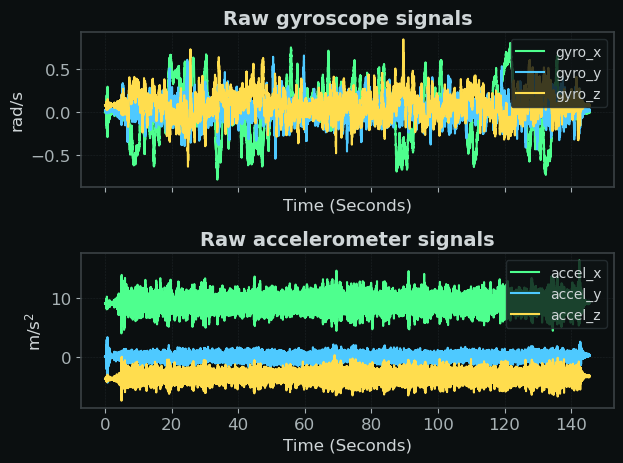

In [111]:
# Plot sensor data

fig, axes = plt.subplots(2, 1, sharex=True)

# Gyro sensors
for c in sensor_cols[:3]:
    axes[0].plot(df['time_sec'], df[c], label=c)
axes[0].set_title('Raw gyroscope signals')
axes[0].set_ylabel('rad/s')
axes[0].set_xlabel('Time (Seconds)')
axes[0].legend(loc='upper right')

# Acceleration sensors
for c in sensor_cols[3:]:
    axes[1].plot(df['time_sec'], df[c], label=c)
axes[1].set_title('Raw accelerometer signals')
axes[1].set_xlabel('Time (Seconds)')
axes[1].set_ylabel('m/s$^{2}$')
axes[1].legend(loc='upper right')

plt.tight_layout()
# plt.savefig("../plots/raw_sensor_signals.png", dpi=300, bbox_inches="tight")
plt.show()

In [112]:
# Compute sample variance and differenced variance
print(f'Sample Variance\n{df[sensor_cols].var()}')
print(f'\nDifferenced sample Variance\n{df[sensor_cols].diff().dropna().var()}')

Sample Variance
gyro_x     0.071238
gyro_y     0.012861
gyro_z     0.022779
accel_x    1.296645
accel_y    0.270197
accel_z    0.722386
dtype: float64

Differenced sample Variance
gyro_x     0.000526
gyro_y     0.006056
gyro_z     0.001567
accel_x    3.903093
accel_y    0.645817
accel_z    2.509868
dtype: float64


accel_x and accel_z seem to be the noisiest sensors

A divergence in the variances normally means that even though a sensor can appear noisy(large R), the latent state is actually stable(small Q)

By comparing the variance and diff-variance we can distinguish between axes(sensor x,y,z) dominated by noise and axes where the latent state actually evolves over time, letting us separate sensor jitters from actual motion in the system.


We use a 6-dimensional state corresponding to the IMU channels:

$$
\mathbf{x}_t =
\begin{bmatrix}
\omega_x(t) \\
\omega_y(t) \\
\omega_z(t) \\
a_x(t) \\
a_y(t) \\
a_z(t)
\end{bmatrix}
$$

Which represents the latent true IMU state at time t(State equation).
The state evolves according to a random-walk model where Wt is process noise:

$$
\mathbf{x}_t = F\,\mathbf{x}_{t-1} + \mathbf{w}_t,
\qquad
\mathbf{w}_t \sim \mathcal{N}(\mathbf{0},\,Q)
$$

Where Q represents the process noise covariance - which decides how much the latent state is allowed to change between timesteps.

and where: 
$$
F = I_6
$$
F is called the transition matrix and it tells us how the latent true state evolves over time, in our case we chose a random walk.

===========================================================================================================================
$$
\mathbf{z}_t =
\begin{bmatrix}
\omega_x^{\text{meas}}(t) \\
\omega_y^{\text{meas}}(t) \\
\omega_z^{\text{meas}}(t) \\
a_x^{\text{meas}}(t) \\
a_y^{\text{meas}}(t) \\
a_z^{\text{meas}}(t)
\end{bmatrix}
$$

This matrix represents the (measurement equation) which contains the raw sensor readings from the data used by the Kalman Filter to update the latent state. It is the linear mapping of a state (latent state + noise) with Vt as measurement noise:

$$
\mathbf{z}_t = H\,\mathbf{x}_t + \mathbf{v}_t,
\qquad
\mathbf{v}_t \sim \mathcal{N}(\mathbf{0},\,R)
$$

Where R represents the measurement noise covariance - which decides how much the kalman filter should trust the raw measurements based on how noisy the readings are at each timestep.

Where:
$$
H = I_6
$$
H is the measurement matrix tells the kalman filter how the latent state maps to the actual IMU Measurements

===========================================================================================================================
The Kalman filter uses Q and R to estimate what the true motion likely was.

## 3. Building the state-space model

In [113]:
# Define F, H, Q, R

dim_x = 6 # Corresponds to the 6 variables (state dimension)
dim_z = 6 # Corresponds to the 6 variables (measurement dimension)

# State transition and Observation matricies: Identity matrix for both of these
F = np.eye(dim_x) # F is a random walk
H = np.eye(dim_z) # H has each sensor exactly measure corresponding state

# Extract per axis noise levels - which become diagonal entries of R
meas_var = df[sensor_cols].var().values

# Build measurement noise covariance R
c_R = 1.0
R = np.diag(c_R * meas_var)

# Build process noise covariance Q and adjust the scaler for Q
q_scale = 0.01
Q = q_scale * np.diag(meas_var)

print(f'F:\n{F}')
print(f'H:\n{H}')
print(f'Q:\n{Q}')
print(f'R:\n{R}')

F:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
H:
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Q:
[[0.00071238 0.         0.         0.         0.         0.        ]
 [0.         0.00012861 0.         0.         0.         0.        ]
 [0.         0.         0.00022779 0.         0.         0.        ]
 [0.         0.         0.         0.01296645 0.         0.        ]
 [0.         0.         0.         0.         0.00270197 0.        ]
 [0.         0.         0.         0.         0.         0.00722386]]
R:
[[0.07123816 0.         0.         0.         0.         0.        ]
 [0.         0.01286056 0.         0.         0.         0.        ]
 [0.         0.         0.02277912 0.         0.         0.        ]
 [0.         0.         0.         1.29664487 0.         0.        ]
 [0.         0.         0.         0.      

### Matricies and their functions
F keeps latent state smooth\
Q lets the state drift\
H ties each observation to its corresponding state\
R weights the measurements according to their variances

### The Kalman Filter
The Kalman filter algorithm runs in two phases at each time step:

Predict
- using the state model to predict the next state before seeing the measurement
- produces the prior state estimate (xhat(t|t-1)) and its covariance

Update 
- compares predicted measurement (Hxhat(t|t-1)) to observed measurement zt
- the difference between the predicted measurement and observed measurement is the innovation or measurement residual.\
We use innovation to calculate kalman gain - which balances the trust between model and measurement.
- updates the state estimate to xhat(t|t)

### Formulas
- **Predicted state**: $\hat{x}_{t\mid t-1}$

- **Predicted covariance**: $P_{t\mid t-1}$

- **Filtered (updated) state**: $\hat{x}_{t\mid t}$

- **Filtered covariance**: $P_{t\mid t}$

- **Observed measurement**: $z_t$

- **Innovation (measurement residual)**: $y_t = z_t - H \hat{x}_{t\mid t-1}$

**Predict step:**

$\hat{x}_{t \mid t-1} = F \, \hat{x}_{t-1 \mid t-1}$

$P_{t \mid t-1} = F \, P_{t-1 \mid t-1} \, F^\top + Q$


**Innovation:**

$y_t = z_t - H \, \hat{x}_{t \mid t-1}$

$S_t = H \, P_{t \mid t-1} \, H^\top + R$


**Kalman gain:**

$K_t = P_{t \mid t-1} \, H^\top \, S_t^{-1}$


**Update step:**

$\hat{x}_{t \mid t} = \hat{x}_{t \mid t-1} + K_t \, y_t$

$P_{t \mid t} = (I - K_t H) \, P_{t \mid t-1}$

In [114]:
# Implement Kalman filter 
kf = KalmanFilter(dim_x=dim_x, dim_z=dim_z)

kf.F = F
kf.H = H
kf.Q = Q
kf.R = R

# Initial state - using first observation
z0 = df[sensor_cols].iloc[0].values
kf.x = z0.reshape(-1, 1) # conver state vector into a column vector

# Initial uncertainty
kf.P = np.eye(dim_x) * 10.0

# Store results
n = len(df)
xs_prior = np.zeros((n, dim_x)) # Predicted states
xs_filter = np.zeros((n, dim_x)) # Filtered states
innovations = np.zeros((n, dim_z))
residuals = np.zeros((n, dim_z))

Z = df[sensor_cols].values

for t in range(n):
    z_t = Z[t]

    # Predict
    kf.predict()
    xs_prior[t] = kf.x.ravel()

    # Innovation before update
    y_t = z_t - (kf.H @ kf.x).ravel()
    innovations[t] = y_t

    # Update
    kf.update(z_t)
    xs_filter[t] = kf.x.ravel()

    # Residual after update using filtered state
    res_t = z_t - (kf.H @ kf.x).ravel()
    residuals[t] = res_t

# Create dataframe for results
df_prior = pd.DataFrame(xs_prior, columns=[c + "_prior" for c in sensor_cols])
df_filter = pd.DataFrame(xs_filter, columns=[c + "_filter" for c in sensor_cols])
df_innovation = pd.DataFrame(innovations, columns=[c + "_innovation" for c in sensor_cols])
df_resid = pd.DataFrame(residuals, columns=[c + '_residuals' for c in sensor_cols])
df_kf = pd.concat([df[['time_sec']], df[sensor_cols], df_filter, df_prior, df_innovation, df_resid], axis=1)

In [115]:
df_kf.columns

Index(['time_sec', 'gyro_x', 'gyro_y', 'gyro_z', 'accel_x', 'accel_y',
       'accel_z', 'gyro_x_filter', 'gyro_y_filter', 'gyro_z_filter',
       'accel_x_filter', 'accel_y_filter', 'accel_z_filter', 'gyro_x_prior',
       'gyro_y_prior', 'gyro_z_prior', 'accel_x_prior', 'accel_y_prior',
       'accel_z_prior', 'gyro_x_innovation', 'gyro_y_innovation',
       'gyro_z_innovation', 'accel_x_innovation', 'accel_y_innovation',
       'accel_z_innovation', 'gyro_x_residuals', 'gyro_y_residuals',
       'gyro_z_residuals', 'accel_x_residuals', 'accel_y_residuals',
       'accel_z_residuals'],
      dtype='object')

In [116]:
# Create moving averages for each channel
channels = ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z"]

t = df_kf['time_sec'].values
dt = np.median(np.diff(t))
print("Approx dt:", dt, 'seconds')

window_sec = 0.50
window = int(round(window_sec/dt))

def add_moving_average(df, chanels, window):
    for ch in channels:
        df[ch + '_ma'] = df_kf[ch].rolling(window=window, center=True).mean()
    return df

df_kf = add_moving_average(df_kf, channels, window)

Approx dt: 0.004999936000004368 seconds


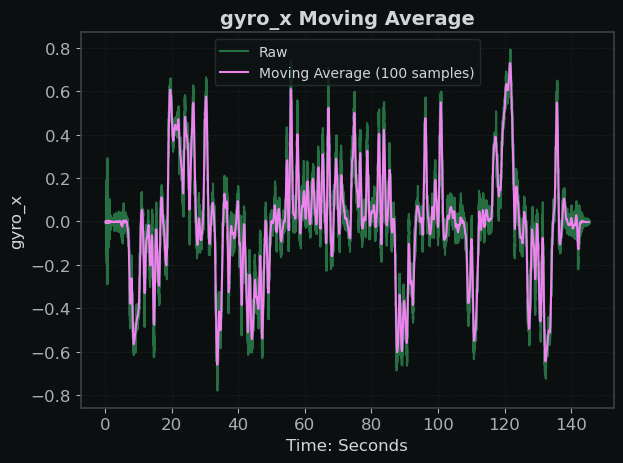

In [117]:
# Visualize moving average for comparison - moving average either does almost nothing or kills the signal
ch = 'gyro_x'

plt.plot(df_kf['time_sec'], df_kf[ch], alpha=0.4, label='Raw')
plt.plot(df_kf['time_sec'], df_kf[ch + '_ma'], label=f'Moving Average ({window} samples)', color='violet')
plt.title(f'{ch} Moving Average')
plt.xlabel('Time: Seconds')
plt.ylabel(ch)
plt.legend()
plt.tight_layout()
# plt.savefig("../plots/moving_average_gyro_x.png", dpi=300, bbox_inches="tight")
plt.show()

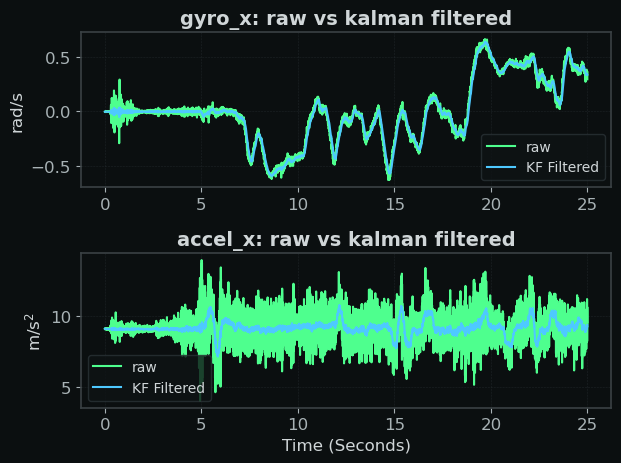

In [118]:
# Raw vs filtered comparison sample
t = df_kf['time_sec'].values
idx_slice = slice(0, min(5000, len(df_kf)))

fig, axes = plt.subplots(2 ,1)

# Plot gyros
gyro_ch = 'gyro_x'
axes[0].plot(t[idx_slice], df_kf[gyro_ch].iloc[idx_slice], label='raw')
axes[0].plot(t[idx_slice], df_kf[gyro_ch + '_filter'].iloc[idx_slice], label='KF Filtered')
axes[0].set_title(f'{gyro_ch}: raw vs kalman filtered')
axes[0].set_ylabel('rad/s')
axes[0].legend()

# Plot accel
acc_ch = 'accel_x'
axes[1].plot(t[idx_slice], df_kf[acc_ch].iloc[idx_slice], label='raw')
axes[1].plot(t[idx_slice], df_kf[acc_ch + '_filter'].iloc[idx_slice], label='KF Filtered')
axes[1].set_title(f'{acc_ch}: raw vs kalman filtered')
axes[1].set_xlabel('Time (Seconds)')
axes[1].set_ylabel(f'm/s$^{2}$')
axes[1].legend()
plt.tight_layout()
# plt.savefig("../plots/filtered_vs_raw_x.png", dpi=300, bbox_inches="tight")
plt.show()

In [119]:
# Create variance reduction table
vr_rows = []
for c in sensor_cols:
    var_raw_c = df_kf[c].var()
    var_filter_c = df_kf[c + '_filter'].var()
    varRed = 1.0 - (var_filter_c / var_raw_c)
    vr_rows.append({'Channel': c, 'var_raw': var_raw_c, 'var_filter': var_filter_c, 'VarianceReduction': varRed})

vr_df = pd.DataFrame(vr_rows)
vr_df = vr_df.sort_values('VarianceReduction', ascending=False)
vr_df['VR_percent'] = vr_df['VarianceReduction'] * 100
vr_df

,Channel,var_raw,var_filter,VarianceReduction,VR_percent
5,accel_z,0.722386,0.025894,0.964155,96.415504
4,accel_y,0.270197,0.017948,0.933575,93.357504
3,accel_x,1.296645,0.120173,0.907320,90.731971
1,gyro_y,0.012861,0.009246,0.281062,28.106166
2,gyro_z,0.022779,0.020015,0.121365,12.136506
0,gyro_x,0.071238,0.069854,0.019437,1.943707


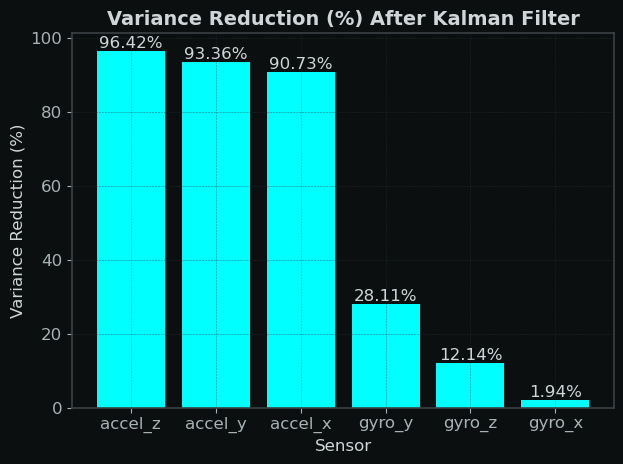

In [120]:
# Plot variance reduction percentage
bars = plt.bar(vr_df['Channel'], vr_df['VR_percent'], color='cyan')

plt.title('Variance Reduction (%) After Kalman Filter')
plt.xlabel('Sensor')
plt.ylabel('Variance Reduction (%)')
plt.gca().bar_label(bars, fmt='%.2f%%')
plt.tight_layout()
# plt.savefig("../plots/variance_reduction_after_kf.png", dpi=300, bbox_inches="tight")
plt.show()

We can see the gyro sensors didnt get smoothed that much - they are less noisy sensors compared to the accelerometer which contains alot of noise due to motion, gravity, vibrations etc.

The kalman filter has cause a:
- 1.9% variance reduction in gyro_x
- 28.1% variance reduction in gyro_y
- 12.1% variance reduction in gyro_z

- 90.7% variance reduction in accel_x
- 93.4% variance reduction in accel_y
- 96.4% variance reduction in accel_z

no negative variance reduction and no variance reduction above 1 meand the Q and R matricies are properly fitted
allowing the filter to denoise the measurement signals effectively while preserving the latent dynamics without oversmoothing

## 4. Diagnostics

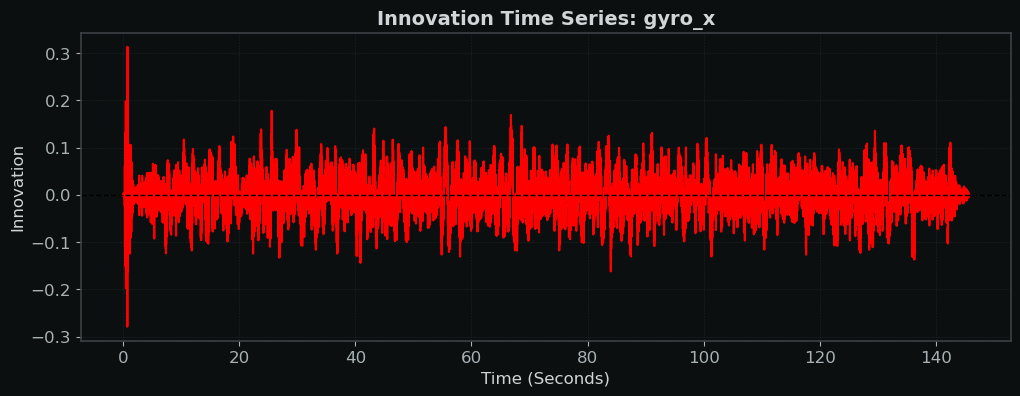

Mean: -4.1378737276990715e-07
Standard Deviation: 0.0391181184343711


In [121]:
# Innovation Residuals: gyro - model seems unbiased and like white noise

ch = 'gyro_x'
innov = df_kf[ch + '_innovation']

plt.figure(figsize=(12,4))
plt.plot(df_kf['time_sec'], innov, color='red')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Innovation Time Series: {ch}')
plt.xlabel('Time (Seconds)')
plt.ylabel('Innovation')
# plt.savefig("../plots/innov_resid_gyro_x.png", dpi=300, bbox_inches="tight")
plt.show()

print('Mean:', innov.mean())
print('Standard Deviation:', innov.std())

Our Statespace model innovations fluctuate around 0, have constant variance, and show no trend - looks like noise 

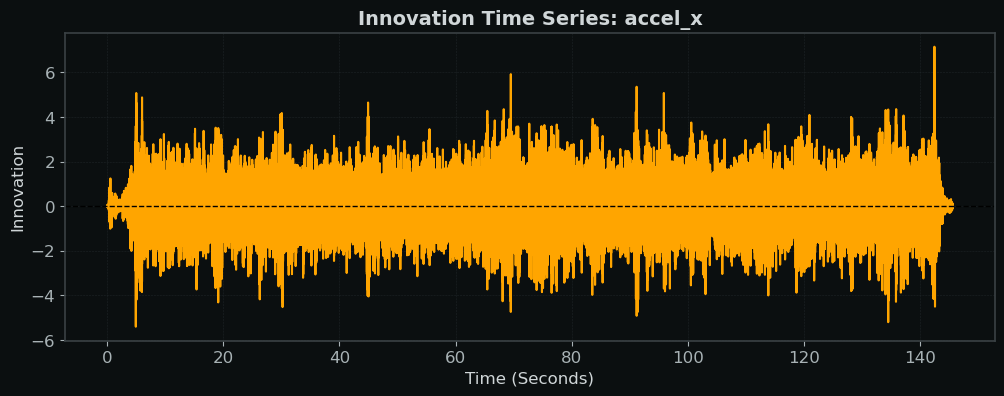

Mean: 5.7615887665195434e-05
Standard Deviation: 1.1402421278276778


In [122]:
# Innovation Residuals: gyro

ch = 'accel_x'
innov = df_kf[ch + '_innovation']

plt.figure(figsize=(12,4))
plt.plot(df_kf['time_sec'], innov, color='orange')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Innovation Time Series: {ch}')
plt.xlabel('Time (Seconds)')
plt.ylabel('Innovation')
# plt.savefig("../plots/innov_resid_accel_x.png", dpi=300, bbox_inches="tight")
plt.show()

print('Mean:', innov.mean())
print('Standard Deviation:', innov.std())

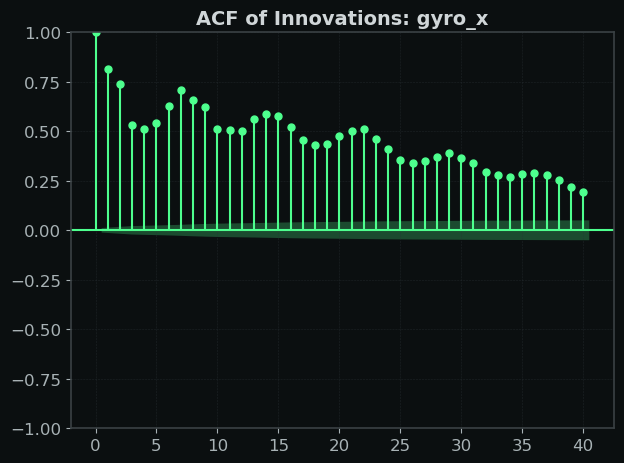

In [123]:
# Plot ACF of innovations
channel = 'gyro_x'
series = df_kf[channel + '_innovation']
plot_acf(series, lags=40)
plt.title(f'ACF of Innovations: {channel}')
plt.tight_layout()
# plt.savefig("../plots/acf_innov_gyro_x.png", dpi=300, bbox_inches="tight")
plt.show()

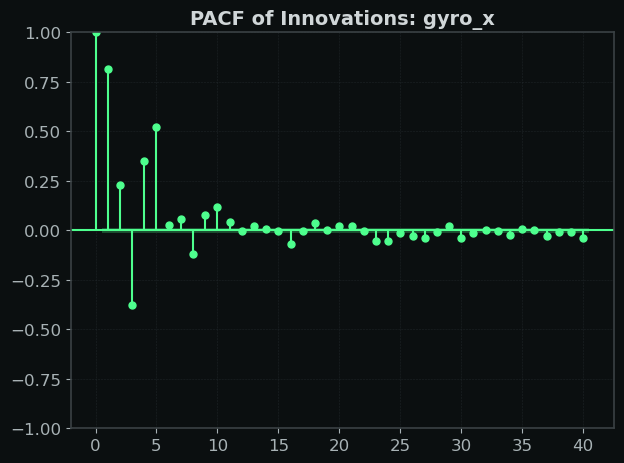

In [124]:
# Plot PACF of innovations
channel = 'gyro_x'
series = df_kf[channel + '_innovation']
plot_pacf(series, lags=40)
plt.title(f'PACF of Innovations: {channel}')
plt.tight_layout()
# plt.savefig("../plots/pacf_innov_gyro_x.png", dpi=300, bbox_inches="tight")
plt.show()

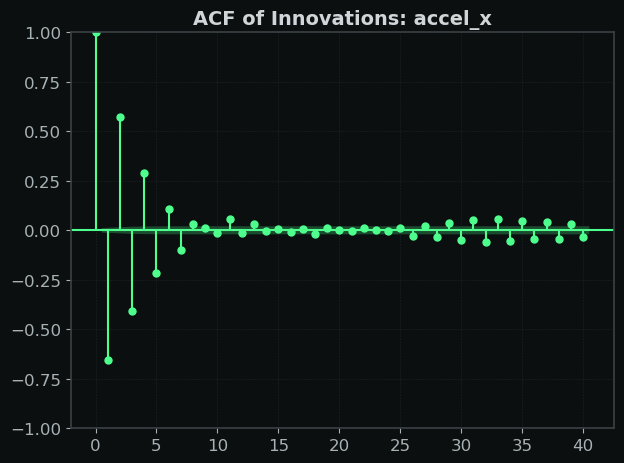

In [125]:
# Plot ACF of innovations
channel = 'accel_x'
series = df_kf[channel + '_innovation']
plot_acf(series, lags=40)
plt.title(f'ACF of Innovations: {channel}')
plt.tight_layout()
# plt.savefig("../plots/acf_innov_accel_x.png", dpi=300, bbox_inches="tight")
plt.show()

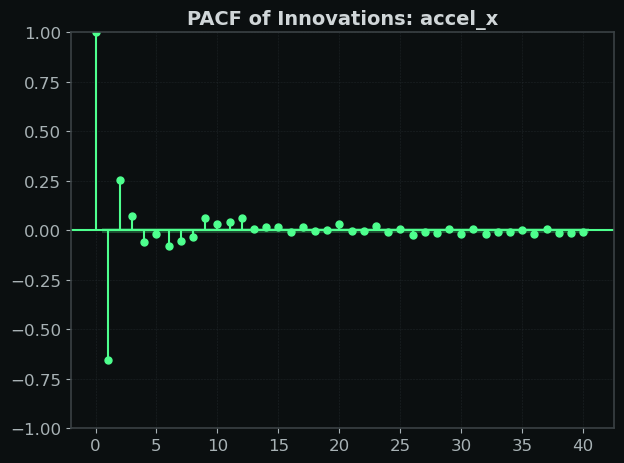

In [126]:
# Plot PACF of innovations
channel = 'accel_x'
series = df_kf[channel + '_innovation']
plot_pacf(series, lags=40)
plt.title(f'PACF of Innovations: {channel}')
plt.tight_layout()
# plt.savefig("../plots/pacf_innov_accel_x.png", dpi=300, bbox_inches="tight")
plt.show()

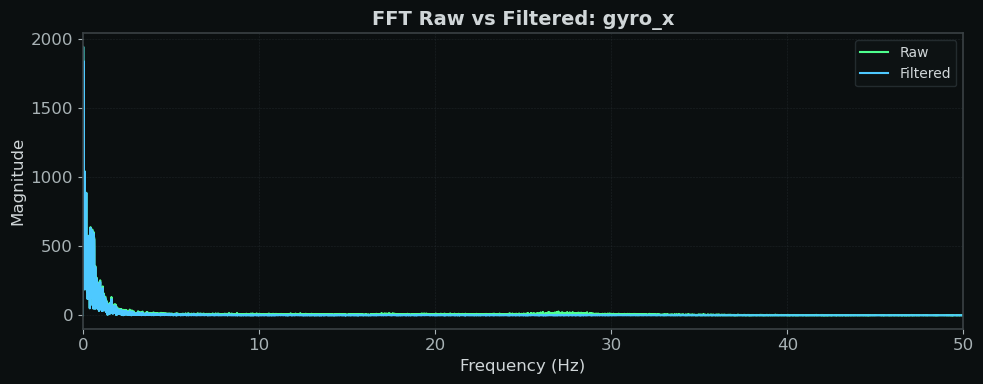

In [127]:
# Plot fast fourier transform
channel = 'gyro_x'
raw = df_kf[channel].values
filt = df_kf[channel + "_filter"].values

t = df_kf['time_sec'].values
dt = np.median(np.diff(t))
freqs = rfftfreq(len(t), dt)

fft_raw = np.abs(rfft(raw - raw.mean()))
fft_filt = np.abs(rfft(filt - filt.mean()))

plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_raw, label='Raw')
plt.plot(freqs, fft_filt, label='Filtered')
plt.xlim(0, freqs.max()/2)
plt.xlabel('Frequency (Hz)')
plt.ylabel("Magnitude")
plt.title(f'FFT Raw vs Filtered: {channel}')
plt.legend()
plt.tight_layout()
# plt.savefig("../plots/FFT_raw_vs_filt_gyro_x.png", dpi=300, bbox_inches="tight")
plt.show()

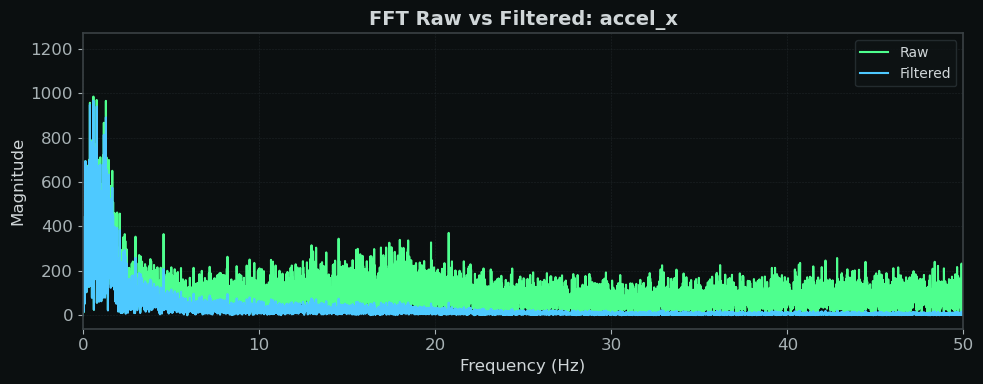

In [128]:
# Plot fast fourier transform
channel = 'accel_x'
raw = df_kf[channel].values
filt = df_kf[channel + "_filter"].values

t = df_kf['time_sec'].values
dt = np.median(np.diff(t))
freqs = rfftfreq(len(t), dt)

fft_raw = np.abs(rfft(raw - raw.mean()))
fft_filt = np.abs(rfft(filt - filt.mean()))

plt.figure(figsize=(10, 4))
plt.plot(freqs, fft_raw, label='Raw')
plt.plot(freqs, fft_filt, label='Filtered')
plt.xlim(0, freqs.max()/2)
plt.xlabel('Frequency (Hz)')
plt.ylabel("Magnitude")
plt.title(f'FFT Raw vs Filtered: {channel}')
plt.legend()
plt.tight_layout()
# plt.savefig("../plots/FFT_raw_vs_filt_accel_x.png", dpi=300, bbox_inches="tight")
plt.show()

## 5. Further Actions
We can fine-tune the Q or R matrices for a specific axis to better specify the model and evaluate the innovation whiteness for each finetune to see what gives the best results.